In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df = pd.read_csv('data/h&mdataset/articles.csv')
df = df.drop(columns=['prod_name','product_code','department_no', 'index_code', 	
       'product_type_name', 'product_group_name',
       'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name', 'detail_desc'])

In [3]:
df.head()

,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,index_group_no,section_no,garment_group_no
0,108775015,253,1010016,9,4,5,1,16,1002
1,108775044,253,1010016,10,3,9,1,16,1002
2,108775051,253,1010017,11,1,9,1,16,1002
3,110065001,306,1010016,9,4,5,1,61,1017
4,110065002,306,1010016,10,3,9,1,61,1017


In [4]:
#train test split on the data
train, test = train_test_split(df, test_size=0.1)

In [5]:
import torch
from torch.utils.data import Dataset
from dataset import myDataset
import os

get_preprocessed_image = True
train_test_split = 0.9
my_path_hm = os.path.join(os.getcwd(), 'data/h&mdataset/images/')
my_path_fash = os.path.join(os.getcwd(), 'data/fashion-dataset/images/')

dataset = myDataset(my_path_hm, my_path_fash, get_preprocessed_image, 'hm')

#Get the indices from the file
train_subset_indices = torch.load('data/h&mdataset/train_subset_indices.pt')
val_subset_indices = torch.load('data/h&mdataset/val_subset_indices.pt')
test_subset_indices = torch.load('data/h&mdataset/test_subset_indices.pt')

test_subset_indices = torch.cat((test_subset_indices, val_subset_indices), 0)

train_dataset = torch.utils.data.Subset(dataset, train_subset_indices)
test_dataset = torch.utils.data.Subset(dataset, test_subset_indices)

/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Skipping .DS_Store as it is not a jpg file


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 64: invalid start byte

In [ ]:
#train/test split the dataframe with the indices

train = df.iloc[train_subset_indices]
test = df.iloc[test_subset_indices]

In [6]:
scaler = StandardScaler()
df_scaled_train = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
train_np = df_scaled_train.to_numpy()

In [7]:
# Do a clustering on the data, for multiple number of cluster and plot the elbow curve

sse = []
range_cluster = range(100, 800, 30)
for i in tqdm(range_cluster):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(train_np)
    sse.append(kmeans.inertia_)


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:03<?, ?it/s]


KeyboardInterrupt: 

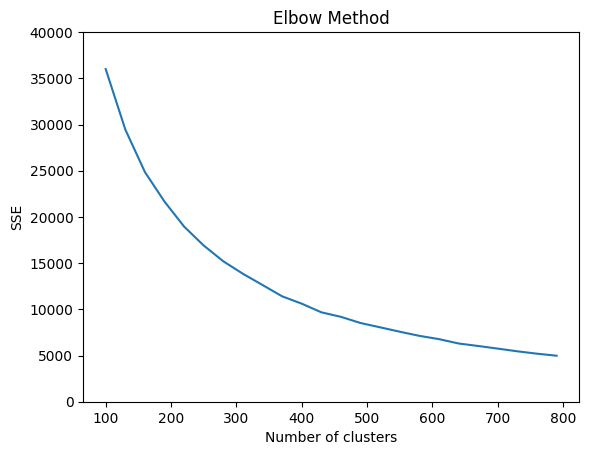

In [ ]:
plt.plot(range_cluster, sse)
plt.title('Elbow Method')
#start y from 0
plt.ylim(0, 40000)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.savefig('models/ElbowGraphs/elbow_curve_tab.png')
plt.show()

#Save the elbow curve plot as a file

In [8]:
#Define the final number of clusters

num_clusters = 400

#Fit the model with the final number of clusters
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)

kmeans.fit(train_np)

KMeans(n_clusters=400, n_init=10, random_state=0)

In [9]:
#Save the model as a file using pickle
import pickle
with open('models/kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

#Save the scaler as a file using pickle
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [11]:
# Save the prediction cluster for each row in the training data as a file and test data as a dataframe

train['cluster'] = kmeans.labels_
#Create a new column with the image name using the dataset method get_image_name that takes the index of the row as an argument
train['img_name'] = train.index.map(dataset.get_name_img)
test['cluster'] = kmeans.predict(test.to_numpy())
test['img_name'] = test.index.map(dataset.get_name_img)

train.to_csv('train_hm_tab_cluster.csv', index=False)
test.to_csv('test_hm_tab_cluster.csv', index=False)
